In [1]:
import os
from keras import applications
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Activation, Dropout, Maximum, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import layer_utils, np_utils
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam, SGD
from keras import Model
from keras import initializers
from keras.callbacks import LearningRateScheduler
from keras.utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.utils import class_weight
import seaborn as sn
from keras.layers import LeakyReLU
import pandas as pd

Using TensorFlow backend.


In [2]:
image_width = 51
image_height = 51

# Change the batchsize according to your system RAM
batch_size = 64

CLASS = {
    'Black-grass': 0,
    'Charlock': 1,
    'Cleavers': 2,
    'Common Chickweed': 3,
    'Common wheat': 4,
    'Fat Hen': 5,
    'Loose Silky-bent': 6,
    'Maize': 7,
    'Scentless Mayweed': 8,
    'Shepherds Purse': 9,
    'Small-flowered Cranesbill': 10,
    'Sugar beet': 11
}

# Same as id_to_label_dict

INV_CLASS = {
    0: 'Black-grass',
    1: 'Charlock',
    2: 'Cleavers',
    3: 'Common Chickweed',
    4: 'Common wheat',
    5: 'Fat Hen',
    6: 'Loose Silky-bent',
    7: 'Maize',
    8: 'Scentless Mayweed',
    9: 'Shepherds Purse',
    10: 'Small-flowered Cranesbill',
    11: 'Sugar beet'
}

train_dir = "D:/Neural_nets_course_Dataset/all/train/"
test_dir = "D:/Neural_nets_course_Dataset/all/test/"

model_check_point_loc = 'D:/Neural_nets_course_Dataset/all/models/resnet_50/resnet_50_model.h5'

#resnet_base = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

In [3]:
def dense_layer(inputs, neurons, activation, drop_rate=0.):
    dropout = Dropout(drop_rate)(inputs)
    fc = Dense(neurons)(dropout)
    fc_norm = BatchNormalization(axis=-1)(fc)
    outputs = Activation(activation=activation)(fc_norm)
    return outputs

In [4]:
def conv_layer(feature_batch,
               feature_map,
               kernel_size=(3, 3),
               strides=(1, 1),
               padding=False):
    if padding:
        processed_feature_batch = ZeroPadding2D((1, 1))(feature_batch)
    else:
        processed_feature_batch = feature_batch

    conv = Conv2D(
        filters=feature_map, kernel_size=kernel_size,
        strides=strides)(processed_feature_batch)
    conv_norm = BatchNormalization(axis=3)(conv)
    outputs = LeakyReLU(1 / 10)(conv_norm)
    return outputs

In [5]:
def model_neural_network():

    inputs = Input(shape=(51, 51, 3))

    # First, Second layer
    conv1 = conv_layer(inputs, 64, padding=False)
    conv2 = conv_layer(conv1, 64, padding=False)
    pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv2)

    # Third, Fourth layer
    conv3 = conv_layer(pool1, 128, padding=False)
    conv4 = conv_layer(conv3, 128, padding=False)
    pool2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv4)

    # Sixth, Seventh, Ninth layer
    conv7 = conv_layer(pool2, 256, padding=False)
    conv8 = conv_layer(conv7, 256, padding=False)
    conv9 = conv_layer(conv8, 256, padding=False)
    pool3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv9)

    # Two Dense layers
    flattened = Flatten()(pool3)
    fc_output = dense_layer(flattened, 128, activation='tanh')
    outputs = dense_layer(fc_output, 12, activation='softmax')

    model = Model(inputs=inputs, outputs=outputs)

    # The first 50 epochs with Adam opt & then 30 epochs with SGD opt.

    #mypotim = Adam(lr=2 * 1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    mypotim = SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=mypotim,
        metrics=['accuracy'])
    model.summary()

    return model

In [6]:
class_labels = os.listdir(train_dir)

In [7]:
def generate_XY(size=51):
    combined_feature_list = []
    labels = []

    for idx, level in enumerate(class_labels):
        retina_root = train_dir + level + '/'
        retina_root_list = os.listdir(retina_root)

        for index, relative_path in enumerate(retina_root_list):
            if relative_path == 'Thumbs.db':
                continue
            source = retina_root + relative_path
            img = image.load_img(source, target_size=(image_width, image_height))
            img_x = image.img_to_array(img)
            #img_x = np.expand_dims(img_x, axis=0)
            
            combined_feature_list.append(img_x)
            labels.append(int(level))
            
    return np.array(combined_feature_list), np.array(labels)
    

In [8]:
X_train, y_train = generate_XY()

In [9]:
y_train_onehot = to_categorical(y_train, 12)

In [10]:
class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train)
                                               ,y_train)

In [11]:
dict(enumerate(class_weight))

{0: 1.5050697084917617,
 1: 1.014957264957265,
 2: 1.3792102206736354,
 3: 0.6478450627386798,
 4: 1.7911010558069382,
 5: 0.8333333333333334,
 6: 0.605249745158002,
 7: 1.7911010558069382,
 8: 0.7671188630490956,
 9: 1.7135642135642135,
 10: 0.7980510752688172,
 11: 1.0281385281385282}

In [12]:
class_weight_dic = dict(enumerate(class_weight))

In [13]:
X_train.shape[1:]

(51, 51, 3)

In [14]:
model = model_neural_network()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 51, 51, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 49, 49, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 49, 49, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 47, 47, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 47, 47, 64)        0         
__________

In [15]:
X = X_train
#X = transformed_data
Y = y_train

In [16]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)
#kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=25)
cvscores = []
trainScores = []
f1Score = []
num_k_folds = 5
fold_counter = 0
val_conmats = []
val_precisions = []
val_recalls = []
val_f_scores = []

In [17]:
for train, test in kfold.split(X, Y):
    # Fit the model
    model.fit(X[train], to_categorical(Y[train]), epochs=30, batch_size=batch_size, class_weight=class_weight_dic, verbose=0)
    
    y_train_pred = model.predict(X[train])
    y_train_pred = np.argmax(y_train_pred, axis=1)
    
    y_validation_pred = model.predict(X[test])
    y_validation_pred = np.argmax(y_validation_pred, axis=1)
    #y_validation_pred = np.argmax(y_validation_pred, axis=1)
    
    [precision, recall, f_score, _] = precision_recall_fscore_support(Y[test], y_validation_pred)
    #print("Validation k-fold #%d - precision: %f, recallL: %f, f-score: %f" % (fold_counter, precision, recall, f_score))
    
    conmat = confusion_matrix(Y[test], y_validation_pred)
    
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f_scores.append(f_score)
    val_conmats.append(conmat)
    fold_counter = fold_counter + 1
    
    trainScores.append(accuracy_score(Y[train], y_train_pred))
    cvscores.append(accuracy_score(Y[test], y_validation_pred))
    
print("\nAveraging the 5-fold results:")
print("%s: %.2f%%" % ('AVG Train Acc ', np.mean(trainScores) * 100))
print("%s: %.2f%%" % ('AVG Validation Acc ', np.mean(cvscores) * 100))
print("Validation precision - mean: %f, stddev: %f" % (np.mean(val_precisions), np.std(val_precisions)))
print("Validation recall - mean: %f, stddev: %f" % (np.mean(val_recalls), np.std(val_recalls)))
print("Validation f-score - mean: %f, stddev: %f" % (np.mean(val_f_scores), np.std(val_f_scores)))
print("Confusion matrix:")
print (sum(val_conmats).astype(float) / fold_counter)


Averaging the 5-fold results:
AVG Train Acc : 97.45%
AVG Validation Acc : 94.83%
Validation precision - mean: 0.948773, stddev: 0.118051
Validation recall - mean: 0.940391, stddev: 0.143333
Validation f-score - mean: 0.941300, stddev: 0.129335
Confusion matrix:
[[ 39.    0.    0.    0.    0.2   0.   12.    0.    1.4   0.    0.    0. ]
 [  0.   76.6   0.    0.    0.    0.    0.    0.    0.2   1.    0.    0.2]
 [  0.    1.2  54.    0.    0.4   0.    0.2   0.    0.    0.4   0.6   0.6]
 [  0.    0.    0.  121.    0.2   0.    0.    0.    0.2   0.    0.6   0.2]
 [  1.    0.    0.6   0.   41.4   0.4   0.4   0.    0.2   0.    0.    0.2]
 [  0.    0.4   0.    1.4   0.2  89.2   1.    0.    0.2   0.2   2.4   0. ]
 [  3.    0.    0.    0.    0.8   0.  125.8   0.    1.    0.    0.2   0. ]
 [  0.    0.    0.    0.4   0.    0.    0.   42.2   0.    0.    1.2   0.4]
 [  0.2   0.    0.    3.4   0.    0.    0.2   0.2  96.6   2.6   0.    0. ]
 [  0.    0.    0.    0.2   0.2   0.    0.    0.    0.4  45.  

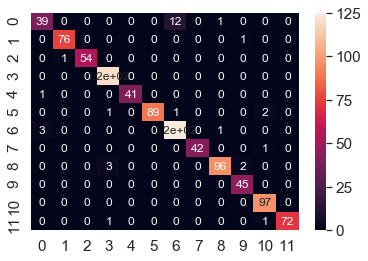

In [18]:
confusion_matrix_array = (sum(val_conmats).astype(float) / fold_counter)
new_confusion_matrix_array = []
for conf_sub_array in confusion_matrix_array:
    new_confusion_matrix_array.append([int(float(e)) for e in conf_sub_array])
        
df_cm = pd.DataFrame(new_confusion_matrix_array, range(12), range(12))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12})# font size

In [19]:
test_image_list = os.listdir(test_dir)

In [20]:
def generate_testXY(size=51):
    test_feature_list = []
    label_names = []

    for index, relative_path in enumerate(test_image_list):
        if relative_path == 'Thumbs.db':
            continue
        source = test_dir + relative_path
        img = image.load_img(source, target_size=(image_width, image_height))
        img_x = image.img_to_array(img)
        #img_x = np.expand_dims(img_x, axis=0)

        label_names.append(relative_path)
        test_feature_list.append(img_x)
        #labels.append(int(level))
            
    return np.array(test_feature_list), np.array(label_names)

In [21]:
X_test, label_list = generate_testXY()

In [22]:
# Predictions
prob = model.predict(X_test, verbose=1)
pred = prob.argmax(axis=-1)

submission_df = pd.DataFrame({
    "file": [label for label in label_list],
    "species": [INV_CLASS[p] for p in pred]
})

794/794 [==============================] - 2s 3ms/step


In [23]:
submission_df.head()

,file,species
0,0021e90e4.png,Small-flowered Cranesbill
1,003d61042.png,Fat Hen
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Common Chickweed
4,00c47e980.png,Sugar beet


In [24]:
submission_df.to_csv('D:/Neural_nets_course_Dataset/all/output/custom/submission.csv', index=False, header=True)